In [24]:
import numpy as np
import scipy
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
from tqdm import tqdm
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import math
import nltk
import pyLDAvis
import pyLDAvis.sklearn as LDAsklearn
# import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF, SparsePCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn import metrics
import xml.etree.ElementTree as etree
import time
import spacy
from spacy import displacy
from wordcloud import WordCloud

In [5]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [6]:
class Model:
    def __init__(self, y_train, y_test):
        self.models = pd.DataFrame(columns=[
            'name',
            'grid_params',
            'best_params',
            'data_use',
            'model',
            'error',
            'Precision',
            'Recall',
            'F_mesure',
            'proportion_de_prédiction',
            'auc_micro',
            'auc_macro',
            'params'
        ])
        self.y_train = y_train
        self.y_test = y_test
        self.x = {}
    def add_model(self, name, model, params=None):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models = self.models.append({
            'name': name,
            'grid_params': params,
            'model': model
        }, ignore_index=True)
    def add_data(self, data_name, x_train, x_test):
        self.x[data_name] = {
            'x_train': x_train,
            'x_test': x_test
        }
    def fit(self, name='all', data_name=None, cv=None):
        if name == 'all':
            self.models.apply(lambda x: self._fit_process(x, data_name, cv), axis=1)
        elif type(name) == str:
            self._fit_process(self.models[self.models['name'] == name], data_name, cv)
        elif type(name) == list:
            for model_name in name:
                self._fit_process(self.models[self.models['name'] == model_name], data_name, cv)
    def _fit_process(self, model, data_name, cv):
        if data_name == None:
            data_name = list(self.x.keys())[-1]
        x_train = self.x[data_name]['x_train']
        x_test = self.x[data_name]['x_test']
        if model['grid_params'] != None:
            grid = GridSearchCV(model['model'], model['grid_params'], n_jobs=-1, cv=cv)
            grid.fit(x_train, self.y_train)
            model['model'] = grid.best_estimator_
        model['model'].fit(x_train, self.y_train)
        print('le model '+model['name']+' à fini son entrainement')
        model['best_params'] = model['model'].get_params()
        model['data_use'] = data_name
        y_pred = model['model'].predict(x_test)
        mcm = multilabel_confusion_matrix(self.y_test, y_pred)
        tn = mcm[:, 0, 0].mean()
        tp = mcm[:, 1, 1].mean()
        fn = mcm[:, 1, 0].mean()
        fp = mcm[:, 0, 1].mean()
        model['error'] = (fp+fn)/(tn+tp+fp+fn)
        model['Precision'] = tp/(tp+fp)
        model['Recall'] = tp/(tp+fn)
        model['F_mesure'] = (2*tp)/(2*tp+fp+fn)
        model['proportion_de_prédiction'] = (tp + fp)/(tp + fn)
        
        y_prob = model['model'].predict_proba(x_test)
        y_proba = []
        for i in y_prob:
            y_proba.append(i[:,0])
        y_proba = 1 - np.array(y_proba).T
        
        n_classes = y_pred.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test[:, i], y_proba[:, i])
            if self.y_test[:, i].sum() == 0:
                tpr[i] = fpr[i]
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y_test.ravel(), y_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes
        
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        model['auc_micro'] = roc_auc["micro"]
        model['auc_macro'] = roc_auc["macro"]
        model['params'] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
        print('tout est bon pour le model '+model['name'])
    def plot_roc(self, name):
        model = self.models[self.models['name'] == name]
        fpr = model['params'].values[0]['fpr']
        tpr = model['params'].values[0]['tpr']
        roc_auc = model['params'].values[0]['roc_auc']
        
        plt.figure(figsize=[15,15])
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
        )
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()

In [7]:
def plot_top_words(model, feature_names, n_top_words, nb_line_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_line_plot)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_line_plot*6):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Préparation

In [8]:
post = pd.read_csv('Data/Posts_Clean_1.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
vocabulary = np.load('Data/Vocabulary.npy', allow_pickle=True)
post = post.sample(n=10000)

In [13]:
X = post["Text"].values
Y = post["Tags_list"].str.split().values
x_train, x_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=9000)

In [14]:
tags_binarizer = MultiLabelBinarizer()
tags_binarizer.fit(y_train)
y_train = tags_binarizer.transform(y_train)
y_test = tags_binarizer.transform(y_test)

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", vocabulary=vocabulary)
count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tf_idn = TfidfTransformer()
tf_idn.fit(x_train_counts)
x_train_tfidf = tf_idn.transform(x_train_counts)
x_test_tfidf = tf_idn.transform(x_test_counts)

## Supervisée

In [30]:
tSVD = TruncatedSVD(n_components=300)
tSVD.fit(x_train_tfidf)
x_train_Tsvd = tSVD.transform(x_train_tfidf)
x_test_Tsvd = tSVD.transform(x_test_tfidf)

In [140]:
acp = PCA(n_components=300)
acp.fit(x_train_tfidf)
x_train_acp = acp.transform(x_train_tfidf)
x_test_acp = acp.transform(x_test_tfidf)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [87]:
lda = LatentDirichletAllocation(
    n_components=30, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=30, n_jobs=-1)

In [88]:
x_train_lda = lda.transform(x_train_counts)

In [102]:
np.concatenate((x_test_tfidf, x_train_lda), axis=1).shape

ValueError: zero-dimensional arrays cannot be concatenated

In [1]:
x_train_counts

NameError: name 'x_train_counts' is not defined

In [35]:
model = Model(y_train=y_train, y_test=y_test)
model.add_data(data_name='tf-idf', x_train=x_train_tfidf, x_test=x_test_tfidf)

In [36]:
forest = RandomForestClassifier(n_jobs=-1)
model.add_model('forest', forest)

In [37]:
model.fit()

le model forest à fini son entrainement
tout est bon pour le model forest


In [16]:
model.models

,name,grid_params,best_params,data_use,model,error,Precision,Recall,F_mesure,proportion_de_prédiction,auc_micro,auc_macro,params
0,forest,None,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",tf-idf,"(DecisionTreeClassifier(max_features='auto', r...",0.013415,0.881303,0.246113,0.384774,0.279261,0.945679,0.903801,"{'fpr': {0: [0.0, 0.0, 0.0, 0.0010030090270812..."


In [190]:
test.apply(lambda x: print(x), axis=1)

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

0    None
1    None
dtype: object

In [188]:
for lop in range(test.shape[1]):
    test.iloc
test.apply(lambda x: print(x))

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

In [142]:
test = pd.DataFrame({'name': 'forest', 'model': forest})

In [147]:
test['model'].apply(lambda x: x.predict(x_test_tfidf))

0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
11    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
12    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
14    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
15    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
16    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
17    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [31]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(x_train_tfidf, y_train)
Y_Pred = forest.predict(x_test_tfidf)

In [72]:
Y_Prob = forest.predict_proba(x_test_tfidf)
Y_Proba = []
for i in Y_Prob:
    Y_Proba.append(i[:,0])
Y_Proba = 1 - np.array(Y_Proba).T

In [137]:
n_classes = y_train.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_Proba[:, i])
    if y_test[:, i].sum() == 0:
        tpr[i] = fpr[i]
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [138]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

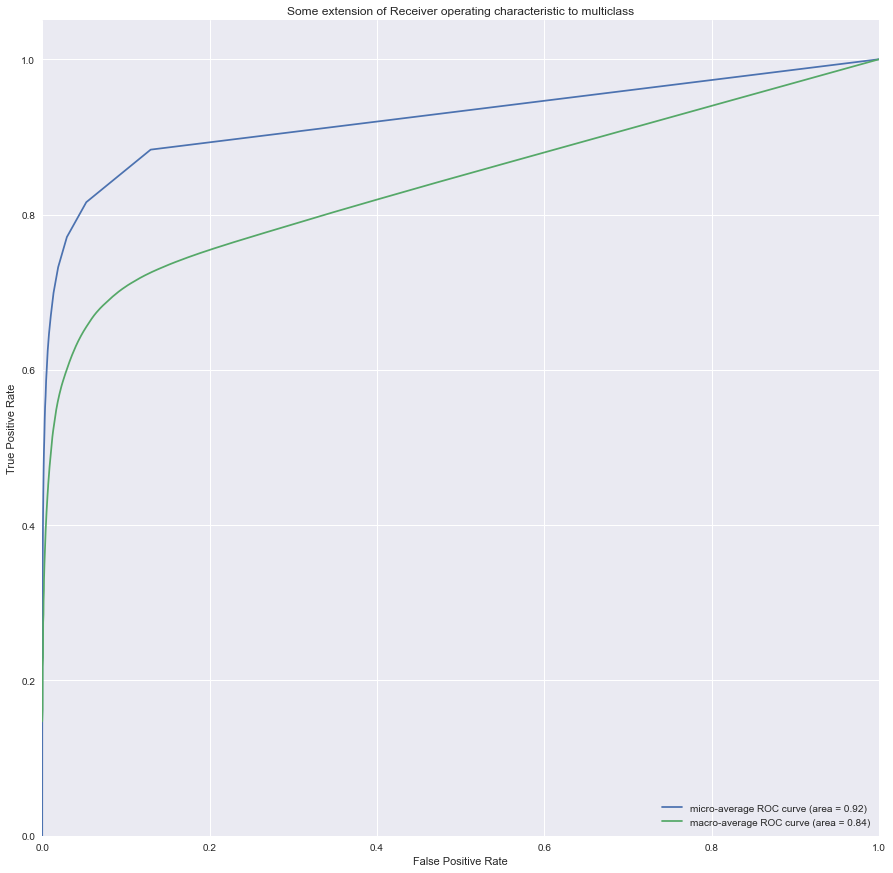

In [156]:
# Plot all ROC curves

plt.figure(figsize=[15,15])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

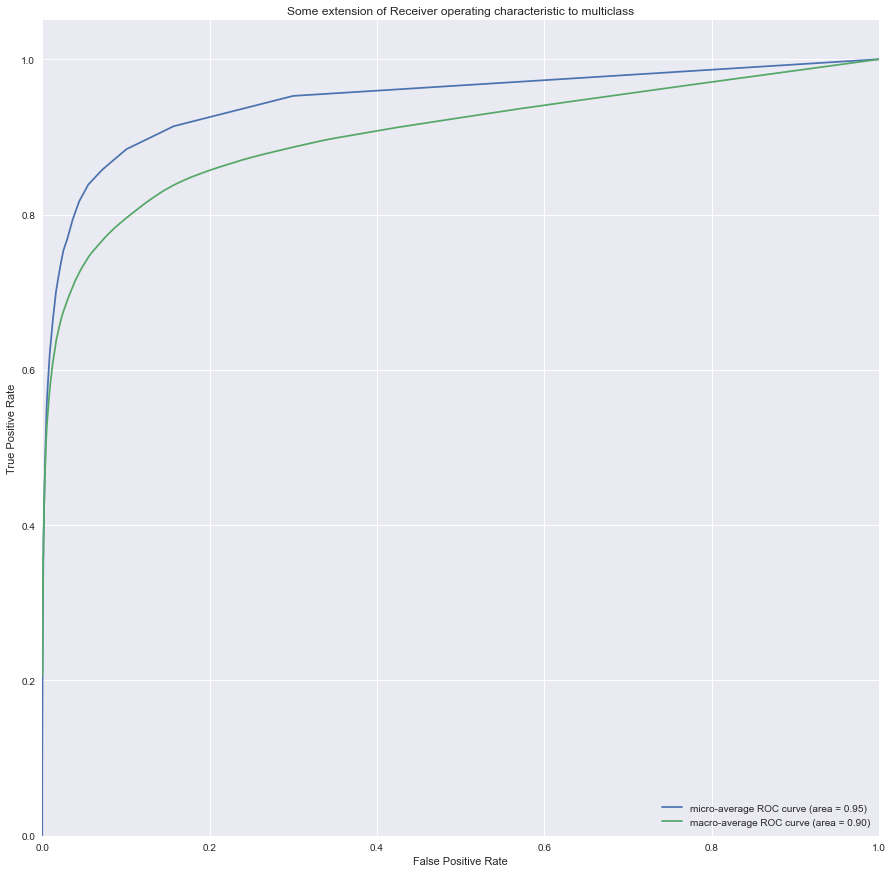

In [38]:
model.plot_roc('forest')

In [83]:
i = 0.5
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()
while (tp + fp) < (tp + fn):
    Y_Est = Y_Proba > i
    mcm = multilabel_confusion_matrix(y_test, Y_Est)
    tn = mcm[:, 0, 0].mean()
    tp = mcm[:, 1, 1].mean()
    fn = mcm[:, 1, 0].mean()
    fp = mcm[:, 0, 1].mean()
    i -= 0.001
print(i)

0.13899999999999968


In [76]:
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()

In [86]:
[[tn,fn], [fp, tp]]

[[1984.695652173913, 4.785024154589372],
 [5.345410628019324, 5.173913043478261]]

In [84]:
(tp + fp)/(tp + fn)

10.519323671497585

In [85]:
tp + fn

9.958937198067634

## Non-Supervisée

In [3]:
texts = count_vect.inverse_transform(x_train_counts)
dico = Dictionary(texts)
corpus = [dico.doc2bow(text) for text in texts]

NameError: name 'count_vect' is not defined

In [40]:
[[(dico[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('13.10', 1),
  ('anyone', 1),
  ('basically', 1),
  ('bus', 1),
  ('cause', 1),
  ('check', 1),
  ('connecting', 1),
  ('crash', 1),
  ('created', 1),
  ('determine', 1),
  ('end', 1),
  ('event', 1),
  ('fine', 1),
  ('gstreamer', 1),
  ('handle', 1),
  ('message', 1),
  ('mode', 1),
  ('multiprocessing', 1),
  ('needed', 1),
  ('otherwise', 1),
  ('parent', 1),
  ('part', 1),
  ('player', 1),
  ('possible', 1),
  ('process', 1),
  ('program', 1),
  ('python', 1),
  ('queue', 1),
  ('reached', 1),
  ('seem', 1),
  ('separate', 1),
  ('solution', 1),
  ('specified', 1),
  ('stream', 1),
  ('ubuntu', 1),
  ('video', 1),
  ('whole', 1),
  ('window', 1),
  ('without', 1),
  ('written', 1),
  ('x', 1)]]

In [41]:
# Build LDA model
lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=20,
                                  random_state=100,
                                  per_word_topics=True)
# Print Perplexity score
print('Perplexity: ', lda.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=texts, 
                                     dictionary=dico, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.673216794720915
Coherence Score:  0.33685801400524856


In [42]:
coherence_score = []
time_fit = []
params = range(5,65,5)
for param in tqdm(params):
    start = time.time()
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                id2word=dico,
                                                num_topics=param,
                                                random_state=24,
                                                per_word_topics=True)
    stop = time.time()
    coherence_model_lda = CoherenceModel(model=lda, 
                                                texts=texts, 
                                                dictionary=dico, 
                                                coherence='c_v')
    coherence_score.append(coherence_model_lda.get_coherence())
    time_fit.append(stop - start)

100%|██████████| 12/12 [03:19<00:00, 16.66s/it]


Text(0, 0.5, "Temps d'execution")

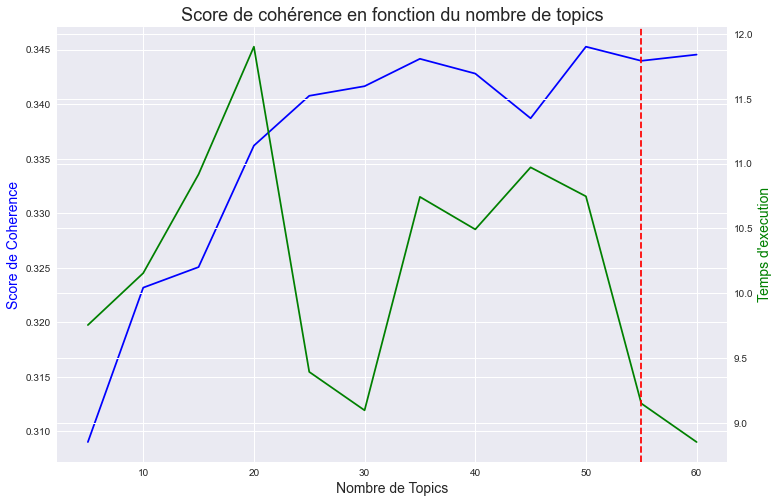

In [43]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(params, coherence_score, color="b")
ax2.plot(params, time_fit, color="g")
plt.axvline(55, color="r", linestyle='--', label="Le meileur paramètre est : 20")
plt.title("Score de cohérence en fonction du nombre de topics", fontsize=18)
ax1.set_xlabel("Nombre de Topics", fontsize=14)
ax1.set_ylabel("Score de Coherence", fontsize=14, color="b")
ax2.set_ylabel("Temps d'execution", fontsize=14, color="g")

In [15]:
best_lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=55)

NameError: name 'corpus' is not defined

In [18]:
gensimvis.prepare(best_lda, corpus, dico)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.005478  0.002465       1        1  2.889121
13    -0.003899  0.001854       2        1  2.814868
26    -0.005502  0.017710       3        1  2.581076
18    -0.006874  0.013271       4        1  2.548472
9     -0.007181  0.008654       5        1  2.507066
0     -0.012066  0.004915       6        1  2.504118
51     0.001044 -0.009732       7        1  2.489950
44    -0.012314 -0.015743       8        1  2.424544
15    -0.029177 -0.007521       9        1  2.396257
28     0.001787  0.004425      10        1  2.374082
5      0.008063  0.000275      11        1  2.323602
22     0.005847 -0.011769      12        1  2.248202
20     0.023863 -0.020413      13        1  2.238279
2     -0.011163  0.004874      14        1  2.189006
46    -0.038745  0.009901      15        1  2.121301
4     -0.011843 -0.011210      16        1  2.108775
47     0.001810 -0.002708      17        1  2.093246
54     0.004096  0.006652      18        1  2.090192
34     0.010336 -0.004075      19        1  2.070833
24     0.007409 -0.006943      20        1  1.957633
11     0.008314  0.007376      21        1  1.931765
53    -0.020475 -0.000808      22        1  1.909908
37    -0.018332  0.004779      23        1  1.882640
3     -0.006633 -0.006897      24        1  1.849347
33     0.010218  0.016004      25        1  1.836663
25     0.014142  0.010961      26        1  1.827428
27     0.014366  0.002978      27        1  1.822484
40     0.002261 -0.013880      28        1  1.815347
21     0.015217 -0.032829      29        1  1.732320
23    -0.004130 -0.008652      30        1  1.680266
19     0.003008 -0.006025      31        1  1.655021
8     -0.027185  0.080129      32        1  1.654846
36    -0.041931 -0.010497      33        1  1.632726
35     0.010662 -0.030870      34        1  1.605892
41    -0.007941  0.005704      35        1  1.600878
43    -0.036600  0.042759      36        1  1.587192
14     0.005934 -0.001552      37        1  1.579432
32    -0.003305  0.026784      38        1  1.553724
45     0.000874 -0.013813      39        1  1.539036
39     0.003664 -0.018427      40        1  1.524196
38     0.015468 -0.000909      41        1  1.473160
30     0.003599  0.016280      42        1  1.441142
49    -0.037393 -0.021740      43        1  1.386857
31    -0.008701 -0.026480      44        1  1.379881
7      0.026252 -0.023636      45        1  1.292807
6     -0.016781  0.061230      46        1  1.291058
10    -0.046582  0.046855      47        1  1.267664
42    -0.008777 -0.057239      48        1  1.253807
12     0.066798 -0.063646      49        1  1.245442
50     0.025313  0.050259      50        1  1.217129
48    -0.006301 -0.034704      51        1  1.160614
16    -0.001532 -0.061705      52        1  1.147385
29    -0.000549 -0.014791      53        1  1.128871
52    -0.004647  0.027217      54        1  1.094179
1      0.151691  0.064906      55        1  1.028268, topic_info=             Term        Freq       Total Category  logprob  loglift
665        update  425.000000  425.000000  Default  30.0000  30.0000
133      possible  581.000000  581.000000  Default  29.0000  29.0000
121          java  472.000000  472.000000  Default  28.0000  28.0000
96           fine  565.000000  565.000000  Default  27.0000  27.0000
31           look  591.000000  591.000000  Default  26.0000  26.0000
18      different  574.000000  574.000000  Default  25.0000  25.0000
395         found  513.000000  513.000000  Default  24.0000  24.0000
189          able  555.000000  555.000000  Default  23.0000  23.0000
365       display  444.000000  444.000000  Default  22.0000  22.0000
602         based  309.000000  309.000000  Default  21.0000  21.0000
848         thing  363.000000  363.000000  Default  20.0000  20.0000
45         second  415.000000  415.000000  Default  19.0000  19.0000
183          give  436.000000  436.0000

In [46]:
lda = LatentDirichletAllocation(
    n_jobs=-1)
params = {"n_components": range(5,65,5)}
grid = GridSearchCV(lda, params, cv=5, n_jobs=-1, verbose=3)
grid.fit(x_train_counts)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LatentDirichletAllocation(n_jobs=-1), n_jobs=-1,
             param_grid={'n_components': range(5, 65, 5)}, verbose=3)

In [18]:
lda = LatentDirichletAllocation(
    n_components=100, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=100, n_jobs=-1)

In [43]:
np.random.shuffle(Y_Pred)

In [42]:
metrics.average_precision_score(y_test, y_pred)

0.01959262295648854

In [44]:
metrics.average_precision_score(y_test, Y_Pred)

0.017301932911900273

In [38]:
lda.components_.shape

(100, 9923)

In [19]:
y_pred = lda.transform(x_test_counts)

In [35]:
y_pred.shape

(2000, 100)

In [36]:
y_test.shape

(2000, 100)

In [33]:
print(metrics.label_ranking_loss(y_test, y_pred))
print(metrics.label_ranking_average_precision_score(y_test, y_pred))
print(metrics.coverage_error(y_test, y_pred))

0.9376678711074453
0.035024947228697485
97.249


In [45]:
print(metrics.label_ranking_loss(y_test, Y_Pred))
print(metrics.label_ranking_average_precision_score(y_test, Y_Pred))
print(metrics.coverage_error(y_test, Y_Pred))

0.9816682138022345
0.03310500000000029
99.0615


In [17]:
LDAsklearn.prepare(lda, x_train_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20     0.175716 -0.039753       1        1  4.951124
5      0.051548  0.015493       2        1  4.760515
21    -0.073834 -0.099497       3        1  4.676721
22    -0.106258 -0.055182       4        1  4.257474
8     -0.029139 -0.054364       5        1  4.209204
19    -0.031987  0.235435       6        1  3.954686
26     0.148249  0.082985       7        1  3.911777
14    -0.045212 -0.075333       8        1  3.727380
24     0.081653  0.051806       9        1  3.610776
13     0.027812  0.051610      10        1  3.580296
23     0.126765 -0.021980      11        1  3.511390
29    -0.077716  0.029359      12        1  3.424994
3     -0.075067  0.121045      13        1  3.332318
28    -0.037365  0.111722      14        1  3.291722
0      0.171744 -0.002045      15        1  3.230255
9     -0.066402 -0.038287      16        1  3.190467
6     -0.016323 -0.128987      17        1  3.072917
27     0.120241 -0.031145      18        1  2.997433
7     -0.050520  0.083425      19        1  2.973318
17    -0.031889 -0.056595      20        1  2.951571
4     -0.069547 -0.070353      21        1  2.932083
12    -0.077368 -0.013712      22        1  2.910505
25     0.142941 -0.059186      23        1  2.899272
15    -0.027488 -0.049520      24        1  2.883161
11    -0.004592 -0.023777      25        1  2.722528
18    -0.078361  0.048764      26        1  2.441180
1     -0.025773  0.023764      27        1  2.433475
16    -0.037401  0.025859      28        1  2.415455
2      0.026902 -0.019380      29        1  2.398039
10    -0.111330 -0.042172      30        1  2.347964, topic_info=             Term        Freq       Total Category  logprob  loglift
3             row  677.000000  677.000000  Default  30.0000  30.0000
31           item  549.000000  549.000000  Default  29.0000  29.0000
0         element  772.000000  772.000000  Default  28.0000  28.0000
62           date  444.000000  444.000000  Default  27.0000  27.0000
2          jquery  697.000000  697.000000  Default  26.0000  26.0000
84           json  396.000000  396.000000  Default  25.0000  25.0000
81        service  492.000000  492.000000  Default  24.0000  24.0000
57     controller  463.000000  463.000000  Default  23.0000  23.0000
9          script  639.000000  639.000000  Default  22.0000  22.0000
65             cs  456.000000  456.000000  Default  21.0000  21.0000
30           test  501.000000  501.000000  Default  20.0000  20.0000
66           loop  441.000000  441.000000  Default  19.0000  19.0000
73        request  443.000000  443.000000  Default  18.0000  18.0000
49            sql  519.000000  519.000000  Default  17.0000  17.0000
112        client  368.000000  368.000000  Default  16.0000  16.0000
44             id  562.000000  562.000000  Default  15.0000  15.0000
15          field  650.000000  650.000000  Default  14.0000  14.0000
29          input  585.000000  585.000000  Default  13.0000  13.0000
78            div  412.000000  412.000000  Default  12.0000  12.0000
123        thread  325.000000  325.000000  Default  11.0000  11.0000
85            api  380.000000  380.000000  Default  10.0000  10.0000
13          click  613.000000  613.000000  Default   9.0000   9.0000
93            xml  363.000000  363.000000  Default   8.0000   8.0000
135     statement  376.000000  376.000000  Default   7.0000   7.0000
51          event  450.000000  450.000000  Default   6.0000   6.0000
...           ...         ...         ...      ...      ...      ...
5326  fingerprint    8.709271   16.295407  Topic30  -6.4813   3.1251
896         slide   21.519863   66.557991  Topic30  -5.5767   2.6225
1972            g    7.071797   12.404647  Topic30  -6.6896   3.1897
2203     exercise    6.685237   11.440477  Topic30  -6.7458   3.2144
578           sdk   23.430237   90.182760  Topic30  -5.4917   2.4038
1361          2.0   13.252819   37.280445  Topic30  -

In [52]:
pyLDAvis.sklearn.prepare(lda, x_test_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.091254 -0.096449       1        1  6.049139
6      0.041228  0.148136       2        1  5.414412
17     0.210142 -0.022282       3        1  5.267044
0     -0.011428  0.094379       4        1  4.553028
29    -0.097936  0.008166       5        1  4.411198
7     -0.090620 -0.132977       6        1  4.220811
16     0.044140  0.131885       7        1  3.948005
24    -0.038021 -0.092653       8        1  3.940703
22    -0.078470  0.018994       9        1  3.934180
5      0.037564 -0.062920      10        1  3.693087
9     -0.003178 -0.008804      11        1  3.369371
15     0.042718  0.105364      12        1  3.292806
14    -0.089795  0.079364      13        1  3.274361
27     0.083950 -0.009938      14        1  3.148900
12     0.169622 -0.053351      15        1  3.128210
10    -0.084828  0.000460      16        1  2.980468
1      0.017755  0.016389      17        1  2.902678
4      0.021776  0.066066      18        1  2.902538
23     0.098290 -0.030637      19        1  2.753023
3     -0.001413 -0.101150      20        1  2.713398
20    -0.073331 -0.086603      21        1  2.597777
11    -0.024026  0.006912      22        1  2.590257
25    -0.045598  0.021431      23        1  2.568867
21    -0.030280  0.104002      24        1  2.478120
28    -0.021235 -0.091970      25        1  2.457499
2      0.009642 -0.091594      26        1  2.406050
18    -0.142045 -0.057232      27        1  2.378289
26    -0.094390  0.065778      28        1  2.364570
19    -0.027745  0.051051      29        1  2.190558
13     0.086258  0.020182      30        1  2.070651, topic_info=             Term        Freq       Total Category  logprob  loglift
3             row  223.000000  223.000000  Default  30.0000  30.0000
62           date  109.000000  109.000000  Default  29.0000  29.0000
2          jquery  182.000000  182.000000  Default  28.0000  28.0000
59        command  124.000000  124.000000  Default  27.0000  27.0000
44             id  131.000000  131.000000  Default  26.0000  26.0000
51          event  102.000000  102.000000  Default  25.0000  25.0000
17     javascript  177.000000  177.000000  Default  24.0000  24.0000
123        thread   78.000000   78.000000  Default  23.0000  23.0000
41            url  134.000000  134.000000  Default  22.0000  22.0000
0         element  181.000000  181.000000  Default  21.0000  21.0000
84           json  107.000000  107.000000  Default  20.0000  20.0000
31           item  136.000000  136.000000  Default  19.0000  19.0000
65             cs   92.000000   92.000000  Default  18.0000  18.0000
74          model  102.000000  102.000000  Default  17.0000  17.0000
78            div   91.000000   91.000000  Default  16.0000  16.0000
286         video   57.000000   57.000000  Default  15.0000  15.0000
37        message  143.000000  143.000000  Default  14.0000  14.0000
79            key  101.000000  101.000000  Default  13.0000  13.0000
93            xml  103.000000  103.000000  Default  12.0000  12.0000
30           test  121.000000  121.000000  Default  11.0000  11.0000
75       property  107.000000  107.000000  Default  10.0000  10.0000
73        request  118.000000  118.000000  Default   9.0000   9.0000
49            sql  125.000000  125.000000  Default   8.0000   8.0000
9          script  193.000000  193.000000  Default   7.0000   7.0000
85            api  104.000000  104.000000  Default   6.0000   6.0000
...           ...         ...         ...      ...      ...      ...
1322    tableview    4.438541   11.540759  Topic30  -5.6608   2.9217
728        minute    6.698000   20.492669  Topic30  -5.2494   2.7590
1426  uitableview    2.891204    6.668974  Topic30  -6.0895   3.0415
1562   preference    2.734265    6.364717  Topic30  -6.1453   3.0324
1046        reset    4.340479   14.220323  Topic30  -5.6832   2.6906
996           pop    4.124624   14.010822  Topic30  -

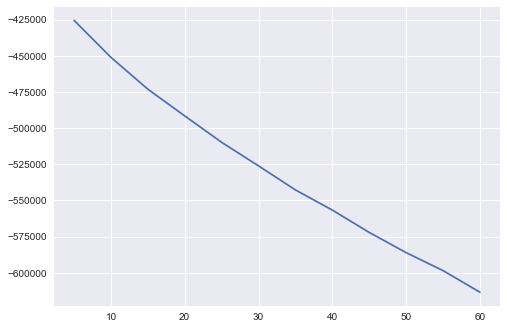

In [53]:
plt.plot(params["n_components"], grid.cv_results_["mean_test_score"])

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(x_test_counts))


# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(x_test_counts))

Log Likelihood:  -96303.1400915431
Perplexity:  101999.2257173945


In [ ]:
# Run NMF
nmf = NMF(n_components=30, random_state=129)
nmf.fit(x_train_counts)
x_nmf = nmf.transform(x_train_counts)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=30, random_state=129)

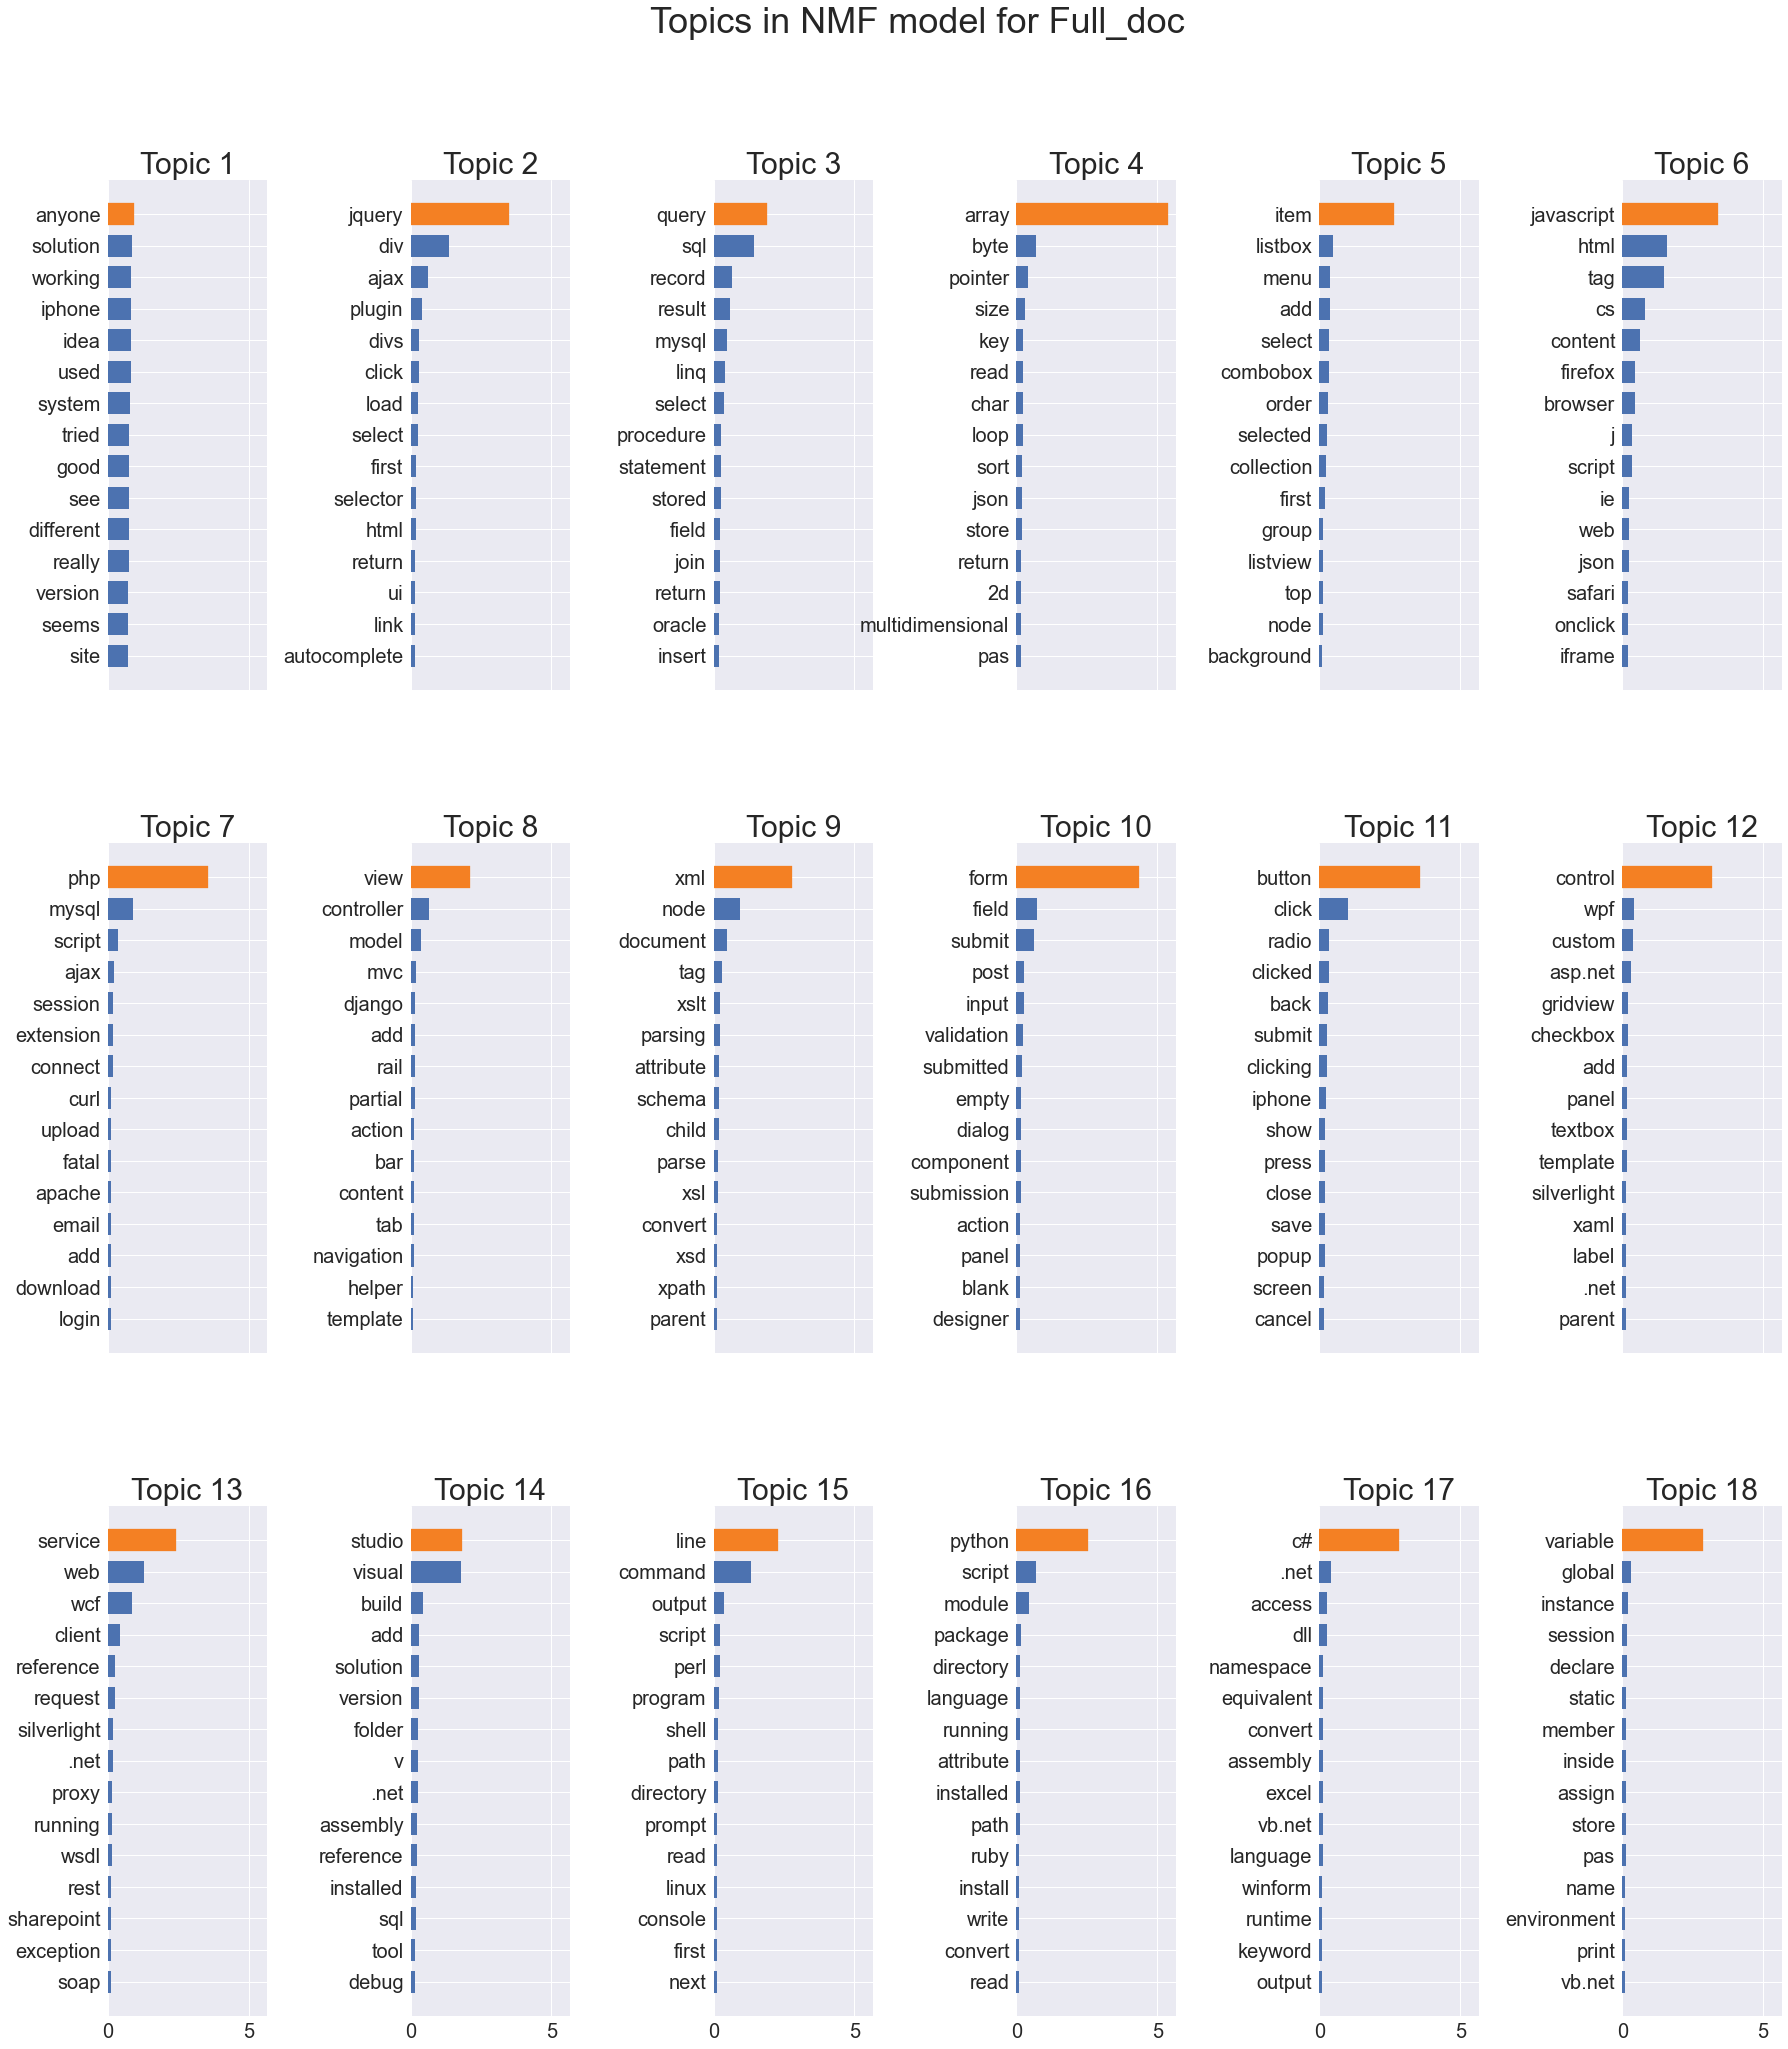

In [ ]:
# Initializing the NMF
full_nmf = NMF(n_components=30, init="nndsvda", random_state=129)

# Fit NMF on Body vectorized
full_nmf.fit(x_train_tfidf)

# Plot the 12 first topics
ff_feature_names = count_vect.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 15, 3,
               'Topics in NMF model for Full_doc')